In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
from glob import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
train_df = glob("chest_xray/train/**/*.jpeg")
test_df = glob("chest_xray/test/**/*.jpeg")
validation_df = glob("chest_xray/val/**/*.jpeg")

In [3]:
train_df[:5], test_df[:5]

(['chest_xray/train\\NORMAL\\IM-0115-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0117-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0119-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0122-0001.jpeg',
  'chest_xray/train\\NORMAL\\IM-0125-0001.jpeg'],
 ['chest_xray/test\\NORMAL\\IM-0001-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0003-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0005-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0006-0001.jpeg',
  'chest_xray/test\\NORMAL\\IM-0007-0001.jpeg'])

- Images in each dataset

In [4]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


- How many of the pictures are of pneumonic lungs and how many are of normal lungs

In [5]:
directory = "chest_xray"
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


- Shuffling the Images

In [6]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['chest_xray\\train\\NORMAL\\IM-0209-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-0627-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-1156-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-0867-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-0944-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-0466-0001.jpeg',
 'chest_xray\\train\\NORMAL\\NORMAL2-IM-1303-0001.jpeg',
 'chest_xray\\train\\NORMAL\\IM-0320-0001.jpeg',
 'chest_xray\\train\\NORMAL\\IM-0187-0001.jpeg',
 'chest_xray\\train\\NORMAL\\IM-0392-0001.jpeg']

- Viewing the Images in X-ray format

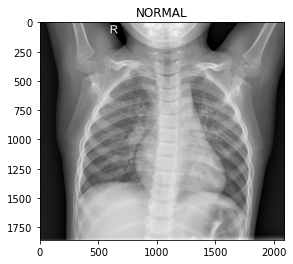

In [7]:
normal_lung_image = load_img("chest_xray/train/NORMAL/IM-0115-0001.jpeg")
plt.imshow(normal_lung_image)
plt.title("NORMAL")
plt.show()

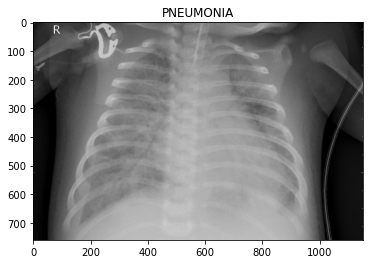

In [8]:
normal_lung_image = load_img("chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
plt.imshow(normal_lung_image)
plt.title("PNEUMONIA")
plt.show()

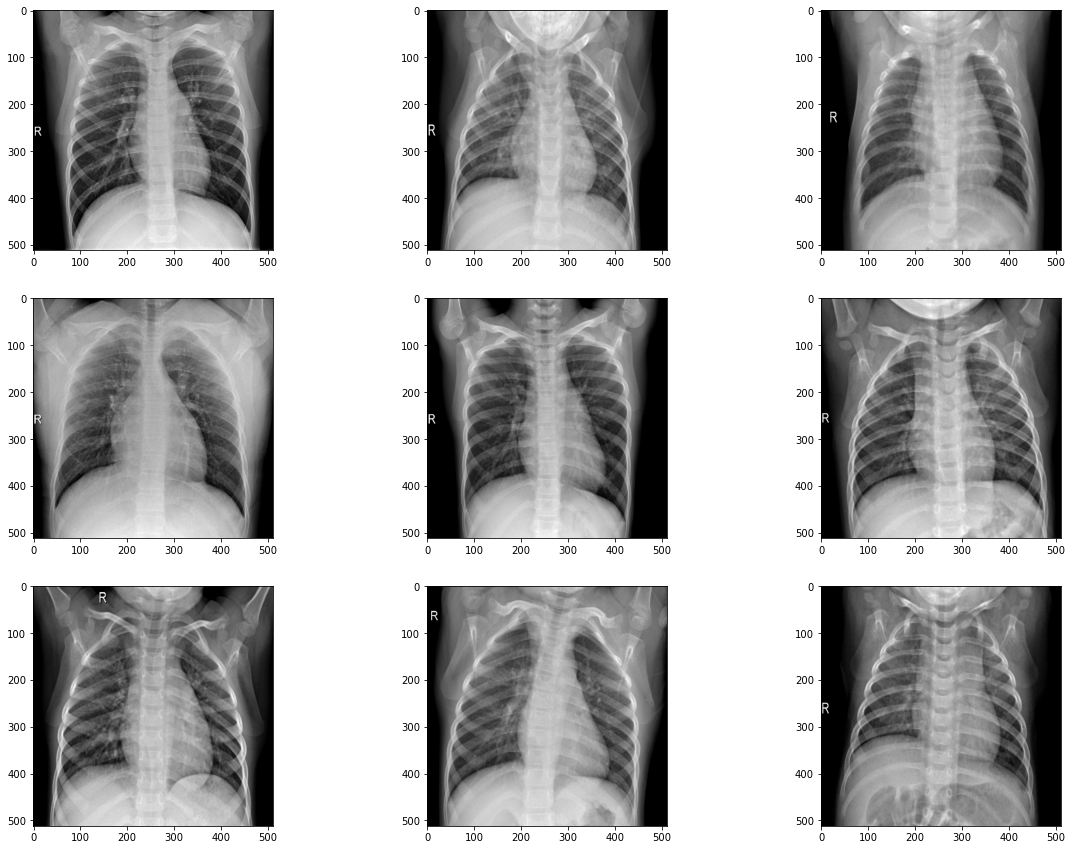

In [9]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

### Image erosion

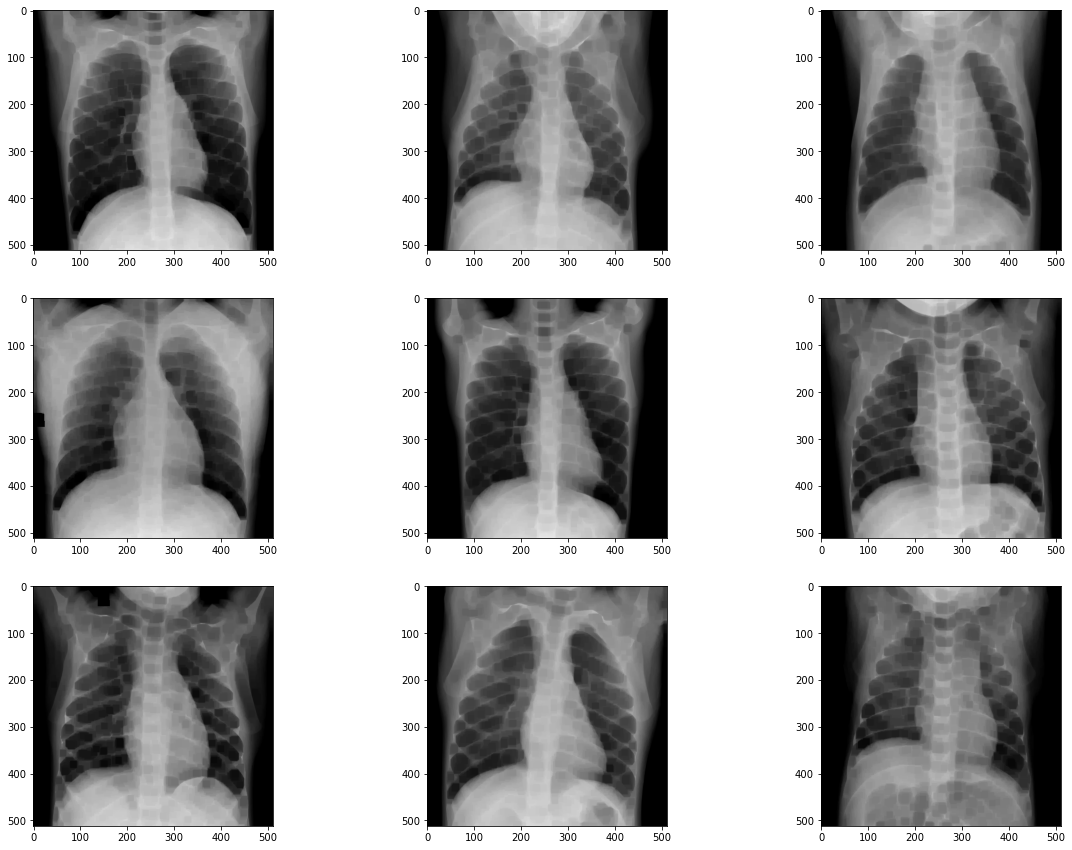

In [10]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

### Image dilation

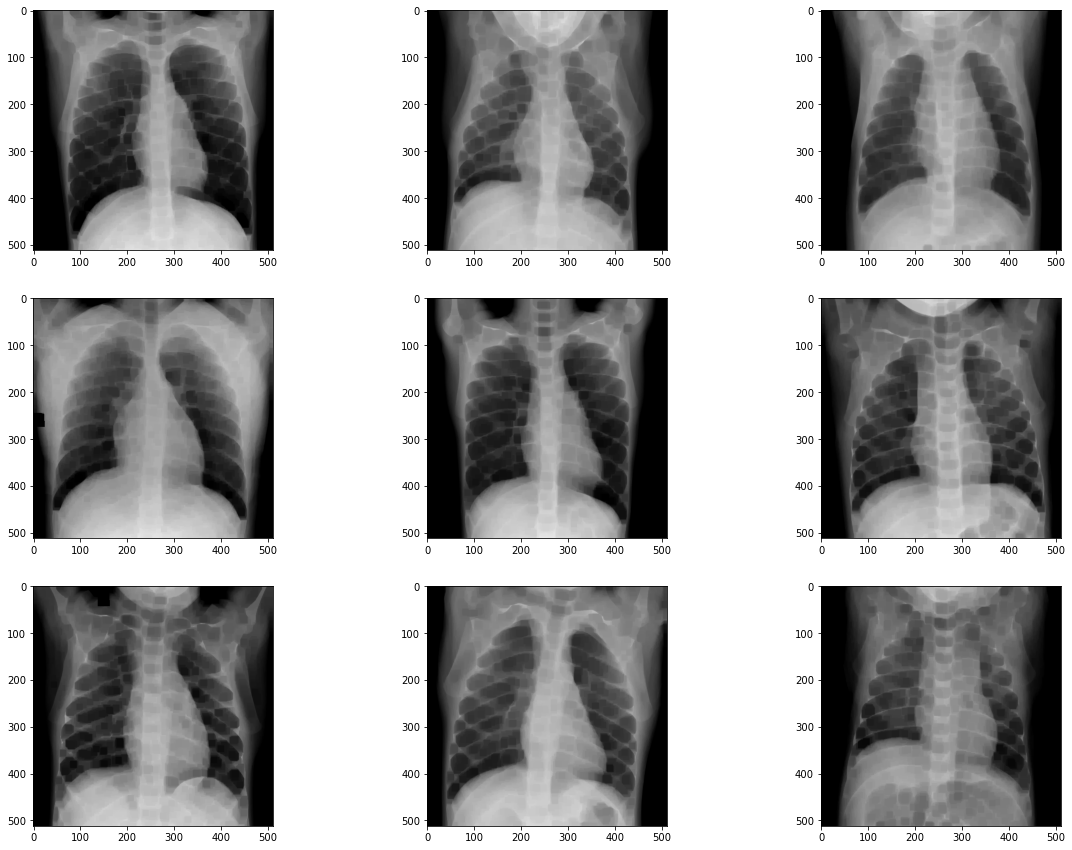

In [11]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

- Converting the images to greyscale and then apply Gaussian blur to them

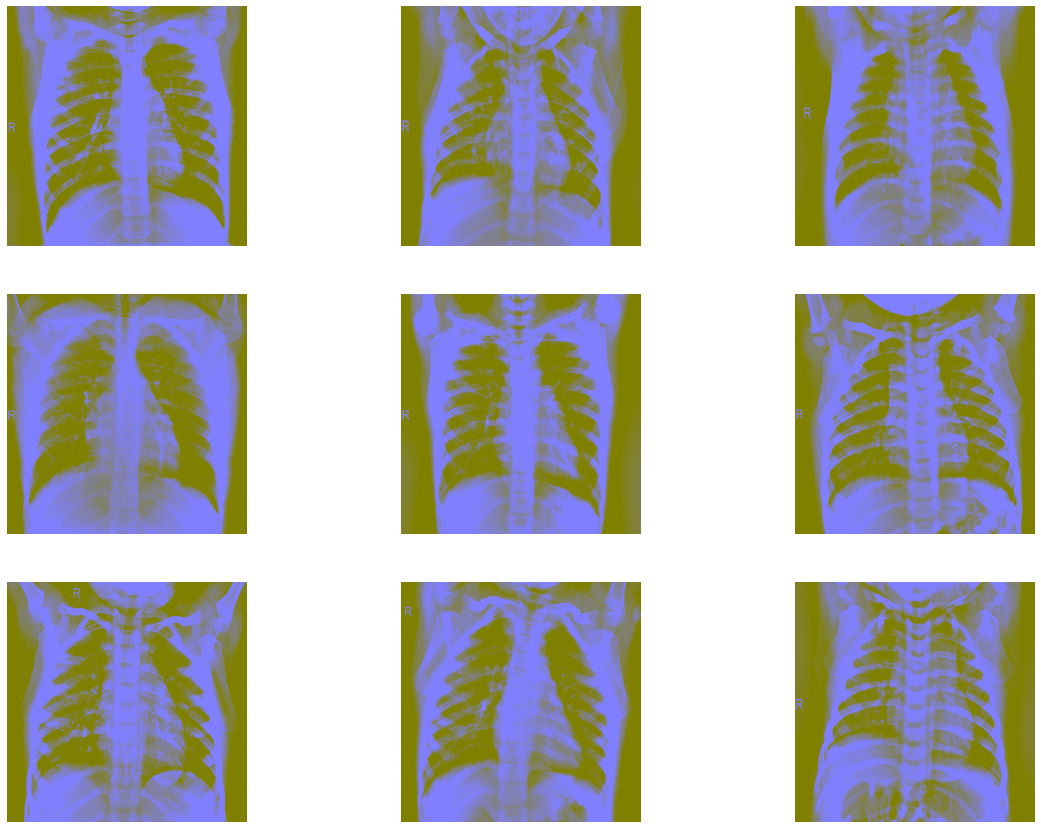

In [13]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

### Canny edge detection.

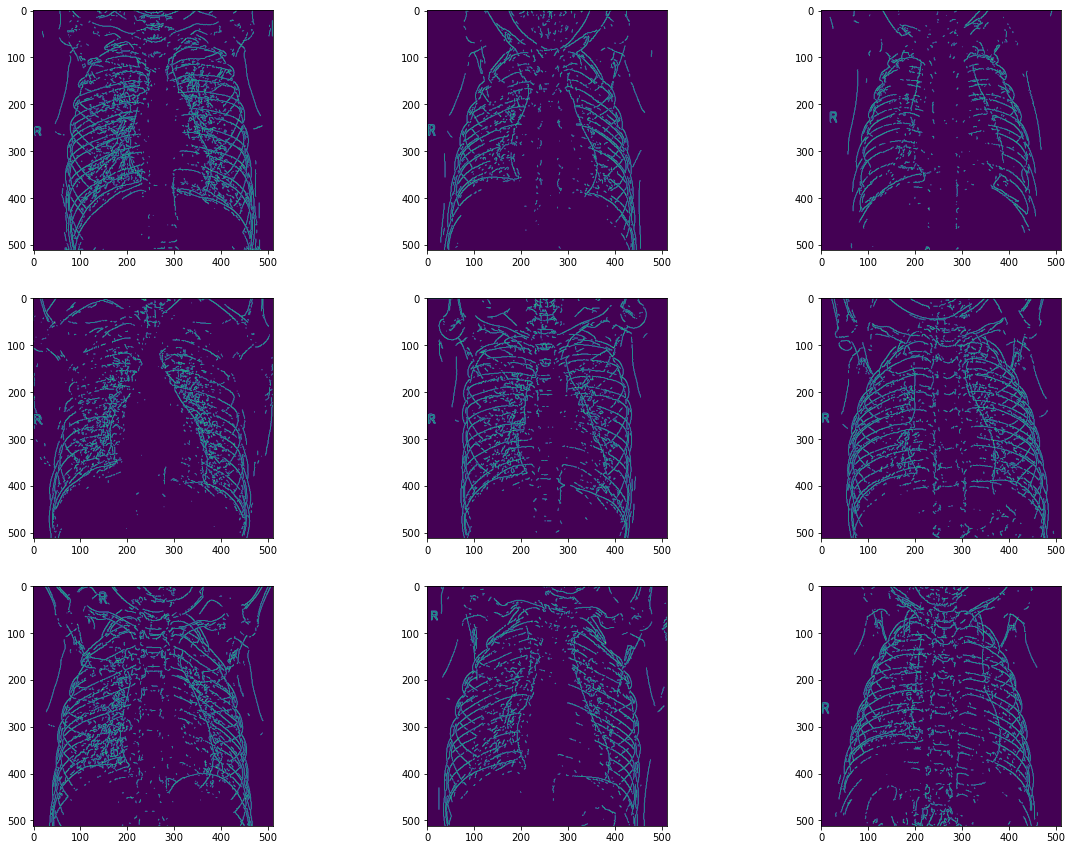

In [14]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

In [15]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
validation_dir = "chest_xray/val"

In [16]:
train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

C:\Users\anant\anaconda3\lib\site-packages\keras\preprocessing\image.py:1446: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# ResNet50V2 model

In [18]:
base_model = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)


for layer in base_model.layers:
    layer.trainable = False

In [19]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [20]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

# freezing the layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model

In [21]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [22]:
early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

# Training the model

In [23]:
history = model.fit(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                               callbacks = [early_stopping_callbacks])

C:\Users\anant\anaconda3\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
C:\Users\anant\anaconda3\lib\site-packages\keras\preprocessing\image.py:1886: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
100/100 [==============================] - 128s 1s/step - loss: 0.5271 - accuracy: 0.8075 - val_loss: 0.3200 - val_accuracy: 0.8750
Epoch 2/20
100/100 [==============================] - 126s 1s/step - loss: 0.2834 - accuracy: 0.8831 - val_loss: 0.2277 - val_accuracy: 0.9375
Epoch 3/20
100/100 [==============================] - 131s 1s/step - loss: 0.2686 - accuracy: 0.8856 - val_loss: 0.3163 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 127s 1s/step - loss: 0.2232 - accuracy: 0.9050 - val_loss: 0.2228 - val_accuracy: 0.8750
Epoch 5/20
100/100 [==============================] - 124s 1s/step - loss: 0.2076 - accuracy: 0.9100 - val_loss: 0.2976 - val_accuracy: 0.8750
Epoch 6/20
100/100 [==============================] - 124s 1s/step - loss: 0.1984 - accuracy: 0.9087 - val_loss: 0.2115 - val_accuracy: 0.9375
Epoch 7/20
100/100 [==============================] - 125s 1s/step - loss: 0.1931 - accuracy: 0.9150 - val_loss: 0.5931 - val_accuracy: 0.7500

# Visualizing performance of the model

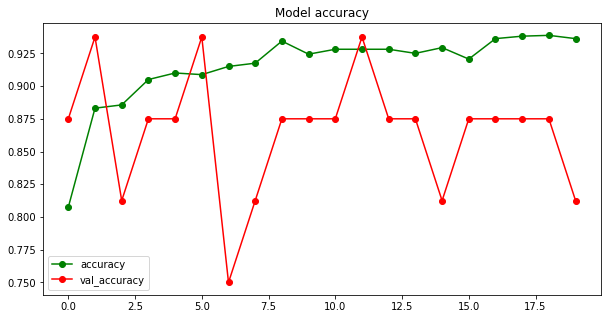

In [24]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

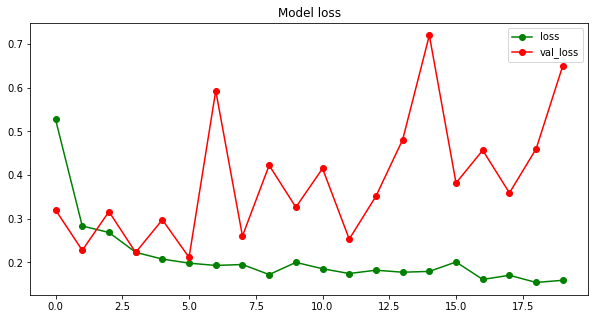

In [25]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

# Evaluating model on the test set

In [27]:
test_loss, test_accuracy = model.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 44s 878ms/step - loss: 0.3001 - accuracy: 0.8990
The testing accuracy is:  89.90384340286255 %
The testing loss is:  30.01301884651184 %


# Prediction model

In [29]:
new_image_path = "chest_xray/pred/pneumonia-lungs.jpg"
test_image = image.load_img(new_image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = np.reshape(test_image, (1, 224, 224, 3))
test_image = test_image / 255

#___________________________________________________________________

result = model.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)

1/1 [==============================] - 1s 1s/step
P N E U M O N I A


In [31]:
model.save("pneumonia_detection_model.h5")
print("Model3 was succesfully saved to disk...")

Model3 was succesfully saved to disk...


- Saving the model

In [33]:
model_loaded = tensorflow.keras.models.load_model("pneumonia_detection_model.h5")
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,837,441
Trainable params: 272,641
Non-t

1/1 [==============================] - 1s 1s/step
This image is 98.212 percent N O R M A L


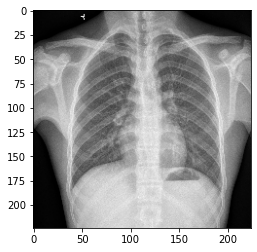

In [37]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("pneumonia_detection_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100 
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))
     
 
image_prediction("chest_xray/pred/normal-lungs.jpeg")

1/1 [==============================] - 1s 997ms/step
This image is 99.975 percent P N E U M O N I A


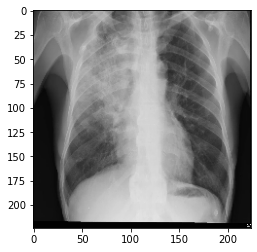

In [38]:
image_prediction("chest_xray/pred/pneumonia-lungs2.webp")

In [39]:
test_dir = "chest_xray/test"
test_data, test_labels = [], []

In [40]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

## Plotting the confusion matrix

_______C o n f u s i o n   m a t r i x_______

20/20 [==============================] - 39s 2s/step


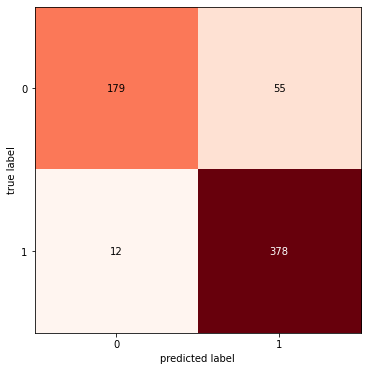

In [41]:
print("_______C o n f u s i o n   m a t r i x_______\n")

predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = matplotlib.pyplot.cm.Reds)
plt.show()

# Displaying the test metrics

In [42]:
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))   

Accuracy: 89.26282051282051%
Precision: 87.29792147806005%
Recall: 96.92307692307692%
F1-score: 91.85905224787363


### Displaying correct and incorrect predicted classes

In [43]:
predictions = list()
preds = model_loaded.predict(test_data)
for i in preds:
    if i >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
predictions[:15]

20/20 [==============================] - 39s 2s/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
correct_predictions = np.nonzero(predictions == test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

# let's look at indices of correct predictions
print("Indices of correct predictions:\n", correct_predictions[:15])

# let's look at indices of incorrect correct predictions
print("\nIndices of incorrect predictions:\n", incorrect_predictions[:15])

Indices of correct predictions:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Indices of incorrect predictions:
 [ 16  37  45  47  67  85  91  93  94  95  97  98 115 116 117]


# Displaying correct predictions

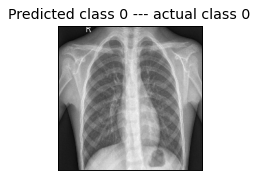

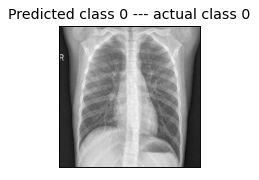

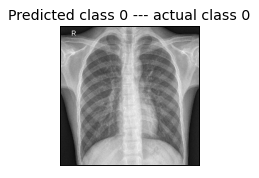

In [45]:
i = 0
for a in correct_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

### Displaying incorrect predictions

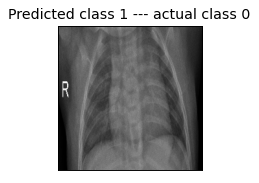

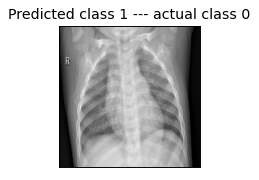

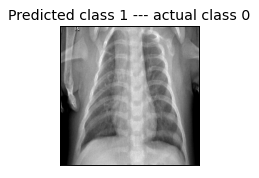

In [46]:
# display incorrect predictions

i = 0
for a in incorrect_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1